In [1]:
import sys
sys.path.insert(0, "..")

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import tqdm

from transtycoon.entities import Field, Warehouse, Position, Transporter
from transtycoon.simulation import OneWayGathering, Simulation
from transtycoon.report import plot_objects

%matplotlib inline

In [92]:
log = False

def evaluate(iwx, iwy):
    field1 = Field(Position(10, -10), 100, name="Field1")
    field2 = Field(Position(-5, 20), 100, name="Field2")
    inter_warehouse = Warehouse(Position(iwx, iwy))
    final_warehouse = Warehouse(Position(-20, 0))
    transporter1 = Transporter(Position(0, 0), speed=5, max_capacity=20, name="Field truck 1", log=log)
    transporter2 = Transporter(Position(0, 0), speed=5, max_capacity=20, name="Field truck 2", log=log)
    transporter3 = Transporter(Position(0, 0), speed=5, max_capacity=50, name="Warehouse truck 1", log=log)

    field1_to_warehouse_task = OneWayGathering(gather_from=field1, deliver_to=inter_warehouse)
    field2_to_warehouse_task = OneWayGathering(gather_from=field2, deliver_to=inter_warehouse)
    warehouse_to_warehouse = OneWayGathering(gather_from=inter_warehouse,
                                             deliver_to=final_warehouse,
                                             wait_for=[transporter1, transporter2],
                                            min_amount=40)

    transporter1.assign_task_queue([field1_to_warehouse_task, field2_to_warehouse_task])
    transporter2.assign_task_queue([field2_to_warehouse_task, field1_to_warehouse_task])
    transporter3.assign_task_queue([warehouse_to_warehouse])

    simulation = Simulation(transports=[transporter1, transporter2, transporter3])
    res = simulation.make_turns()
    assert final_warehouse.resources == 200
    return res["simulation_steps"]

In [93]:
y_labels = np.arange(-15, 30)
x_labels = np.arange(-25, 15)

ev = []
for x in tqdm.tqdm(x_labels):
    _ev = []
    for y in y_labels:
        _ev.append(evaluate(x, y))
    ev.append(_ev)

df = pd.DataFrame(ev, index=x_labels, columns=y_labels)

100%|██████████| 40/40 [00:25<00:00,  1.59it/s]


In [94]:
field1 = Field(Position(10, -10), 100, name="Field1")
field2 = Field(Position(-5, 20), 100, name="Field2")
final_warehouse = Warehouse(Position(-20, 0))
final_warehouse.resources=300

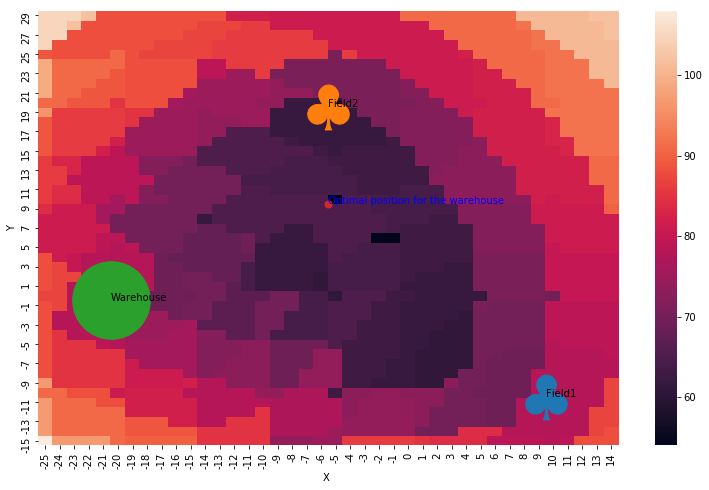

In [95]:
shift=[-x_labels[0], -y_labels[0]]

fig, ax = plt.subplots(figsize=(13, 8))
sax = sns.heatmap(df.T, ax=ax)
sax.set(xlabel='X ', ylabel='Y')

fig, ax = plot_objects(fields=[field1, field2],
             warehouses=[final_warehouse],
             ax=ax, shift=shift)
plt.gca().invert_yaxis()


best_warehouse_position = np.unravel_index(df.values.argmin(), df.shape)
ax.scatter(best_warehouse_position[0], best_warehouse_position[1], s=50)
ax.annotate("Optimal position for the warehouse", (best_warehouse_position[0], best_warehouse_position[1]), color="b")